In [14]:
import yfinance as yf

!pip install pandas_market_calendars
import pandas_market_calendars

import datetime, time
import pandas as pd
import numpy as np

url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

#clears the cell output after all the install messages
from IPython.display import clear_output
clear_output(wait=True)

#see all columns
pd.set_option('display.max_columns', None)

In [59]:
# Import saved data
df = pd.read_pickle('df_ohlc_4ML_1500_obs.pkl')['df']
ohlc = pd.read_pickle('df_ohlc_4ML_1500_obs.pkl')['ohlc']
print(df.shape, ohlc.shape)

time.sleep(5)
clear_output()

In [ ]:

#st = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/st.pkl')

#@title Clean / Organize dataframe { form-width: "25%" }
def clean_df(st):
  # Numerize the columns that contain numbers
  int_cols = ['No.', 'Volume', 'Advancing issues','Declining issues', 'New High',
              'New Low', 'Above SMA50', 'Below SMA50', 'Above SMA200', 'Below SMA200']

  num_cols = ['P/FCF', 'EPS this Y', 'Float Short', 'Short Ratio',
        'Perf Week', 'Perf Month', 'Perf Quart', 'Perf Half', 'Perf Year','Beta',
        'ATR', 'Volatility W', 'Volatility M', 'SMA20', 'SMA50','SMA200', 'RSI',
        'Rel Volume', 'Price', 'Change', 'Open_gf', 'High_gf', 'Low_gf',
        'Close_gf', 'Sector score', 'Industry score'] + int_cols

  st[num_cols] = pd.to_numeric(st[num_cols].stack(), errors='coerce').unstack()
  st[int_cols] = st[int_cols].astype('Int64')

  # Numerize the columns that contain abbreviated big numbers e.g. 1B, 1M
  m = {'K': 3, 'M': 6, 'B': 9, 'T': 12}
  for col in ['Market Cap', 'Avg Volume']:
    st[col] = [int(float(i[:-1]) * 10 ** m[i[-1]]) for i in st[col]]

  # Convert strings columns
  str_cols = ['Ticker', 'Company', 'Sector', 'Industry', 'Country']
  st[str_cols] = st[str_cols].astype('string')

  # Convert dates to datetime
  st['Date']= pd.to_datetime(st['Date'], errors='coerce')
  st['IPO Date']= pd.to_datetime(st['IPO Date'], format='%m/%d/%Y', errors='coerce')

  # Discard weekends and trading bankholidays if any
  nyse = pandas_market_calendars.get_calendar('NYSE')
  trading_days = nyse.valid_days('2021-10-01', datetime.date.today()).tz_localize(None)
  #trading_days = pd.bdate_range(start='2021-10-22', end=datetime.date.today()) #in reality it's just calendar days with weekends stripped out
  st = st[st['Date'].isin(trading_days)]

  return st

st = clean_df(st)

# Define batch of columns for masking views
o = ['Date', 'Ticker', 'Company', 'Price', 'Change']
fundamentals = ['No.','Earnings','P/FCF', 'EPS this Y', 'Float Short', 'Country',
               'Market Cap', 'Short Ratio', 'Perf Week', 'Perf Month', 'Perf Quart',
               'Perf Half', 'Perf Year', 'Beta', 'IPO Date']
market_breadth = ['Sector', 'Industry', 'Sector score', 'Industry score', 'Advancing issues',
                  'Declining issues', 'New High', 'New Low', 'Above SMA50', 'Below SMA50',
                  'Above SMA200', 'Below SMA200']
technicals = [] # to be initialized when ta is deployed
ta_fvz = ['SMA20', 'SMA50', 'SMA200', 'RSI', 'ATR', 'Avg Volume', 'Rel Volume', 'Open_gf',
          'High_gf', 'Low_gf', 'Close_gf']

# under work / Get next Earnings date
  # datetime.datetime.strptime(stocks.iloc[0].Earnings[:-2], '%b %d')
  # stocks.iloc[0].Earnings[:-2] + ' {Year}'

print(f'Cells  {st.size} / {st.shape}  |  Non null {st.notnull().values.sum()} / {round(st.notnull().values.sum() / st.size, 3)} ')

In [ ]:
#select a sample which has complete data, including sector and industry strength
filter_raw = (st['Sector score'].notnull()) & (st['Date'] < pd.Timestamp.today() - pd.Timedelta(days=40))
df = st[filter_raw].sample(2200, random_state=19).copy()
df

In [ ]:
#@title download ohlc{ form-width: "25%", display-mode: "form" }
from pandas.tseries.offsets import BDay

#function to nicely fetch ohlc from yfinance
def get_ohlc(df, start_date = None, end_date = datetime.datetime.today().strftime('%Y-%m-%d')):

  if start_date is None:
   start_date = (datetime.datetime.strptime(end_date, '%Y-%m-%d') - BDay(220)).strftime("%Y-%m-%d")

  tickers = list(df['Ticker'].unique())

  ohlc = yf.download(tickers, start=start_date, end=end_date, rounding=True, group_by='Ticker')
  ohlc.reindex(level=1, columns=["Open", "High", "Low", "Close", "Adj Close"])
  ohlc = ohlc.rename(str.lower, axis='columns', level=1)

  return ohlc

ohlc = get_ohlc(df, end_date=df.Date.max()+BDay(20), start_date=df.Date.min()-BDay(220))

#drop tickers with no ohlc data from yf (avoid errors with talib down the line and drop na's)
tickers_no_yf_data = [i for i in list(ohlc.columns.levels[0]) \
                      if (ohlc[i].isnull().values.all() == True) \
                      and (i in df.Ticker.unique())]

df = df.drop(index = df[df.Ticker.isin(tickers_no_yf_data)].index )
print(f'{len(tickers_no_yf_data)} tickers dropped as ohlc N/A: {tickers_no_yf_data}')

In [47]:
#@title update_df{ form-width: "25%", display-mode: "form" }
def update_df(df: pd.DataFrame, dct: dict) -> pd.DataFrame:
  '''
  Function to update observations df with technical data from a dict 'dct' of
  dataframes whose keys are the tickers.
  '''
  cd_join = pd.concat(dct.values(), axis=0).set_index(['Ticker'], append=True)
  cd_join = cd_join.round(4)
  df['idx'] = df.index
  df = df.set_index(['Date', 'Ticker'])

  #if df has already the cols that the function has to add, drop those cols before .join
  df = df.drop(columns = [i for i in df.columns if i in cd_join.columns])
  df = df.join(cd_join, how='left', sort=False)

  df = df.reset_index().set_index('idx', drop=True)

  return df

In [61]:
#@title Technical Analysis v4{ form-width: "25%", display-mode: "form" }
def get_ta4(df, ohlc, mas=False, candles=False , oscilators=False, bands=False, price_action=False):
  """
  Adds OHLCV and techinal indicators in the dataframe.
  Take a df df which must contain 'Date' and 'Ticker' columns.
  Based on ('Date', 'Ticker') index, its search in ohlc df which contains hisorical price data.
  It computes the ta and will add it on a df row corresponding to matching ('Date', 'Ticker') index.

  Parameters
  ----------
  df : pandas.core.frame.DataFrame
      DataFrame containing the Date and the Ticker of the event to be analyzed.

  ohlc : pandas.core.frame.DataFrame
      Multiindex DataFrame containing OHLCV of various tickers.

  *args: boolean
      If True adds the indicators group. Default False

  Returns
  -------
  Tuple (df, technicals)
  df: pandas.core.frame.DataFrame
      The updated df df with ta columns and values corresponding to ('Date', 'Ticker').
  ta: pandas.core.frame.DataFrame
  technicals: list
      List containing the added columns

  """

  tickers = list(df['Ticker'].unique())
  ohlcv_cols = list(ohlc.columns.levels[1])

  dct = {}
  for ticker in sorted(tickers):
    ta = ohlc[ticker].copy()

    ta.insert(0, 'Ticker', ticker)

    open = ta[ 'open']
    close = ta[ 'close']
    high = ta[ 'high']
    low = ta[ 'low']
    volume = ta[ 'volume']
    args = [open, high, low, close]
    typp = talib.TYPPRICE(high, low, close)
    ta[ 'Relvol'] = volume / talib.SMA(volume, 20)
    ta[ 'RSI5'] = talib.RSI(close, 5)
    ta[ 'RSI10'] = talib.RSI(close, 10)

    if oscilators == True:
      ta['RSI5'] = talib.RSI(close, 5)
      ta['RSI10'] = talib.RSI(close, 10)
      ta['RSI14'] = talib.RSI(close, 14)
      ta['lowRSI10'] = talib.MIN(ta['RSI10'], 10)
      ta['ROC'] = talib.ROC(close, 1) / 100
      ta['ROC3'] = talib.ROC(close, 3) / 100
      ta['ROC5'] = talib.ROC(close, 5) / 100
      ta['MOM'] = talib.MOM(close, 5)
      ADR5 = talib.SMA(high / low, 5) - 1
      ADR21 = talib.SMA(high / low, 21) - 1
      ta['ADR5'] = ADR5
      ta['ADR21'] = ADR21
      #Kaufmann efficiency ratio
      ta['kfr10'] = ta['close'].diff(10) / ta['close'].diff().abs().rolling(10).sum()

    if mas == True:
      ta['EMA10'] = talib.EMA(close, 10)
      ta['EMA20'] = talib.EMA(close, 20)
      ta['EMA50'] = talib.EMA(close, 50)
      ta['EMA100'] = talib.EMA(close, 100)
      ta['SMA150'] = talib.SMA(close, 150)
      ta['SMA200'] = talib.SMA(close, 200)
      #relative position of moving averages with respect to last close.
      for label in ['EMA10', 'EMA20', 'EMA50', 'EMA100', 'SMA150', 'SMA200']:
        ta[f'r_{label}'] = ta[label] / close - 1

    if bands == True:
      ta['BB_up'], \
      ta['BB_mid'], \
      ta['BB_lo']  = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

      ta['KB_up'] = talib.EMA(close, 20) + 2*talib.ATR(high, low, close, 10)
      ta['KB_lo'] = talib.EMA(close, 20) - 2*talib.ATR(high, low, close, 10)

    if candles == True:
      ta['ENGULFING'] = talib.CDLENGULFING(*args)
      ta['DOJI'] = talib.CDLDOJI(*args)
      ta['HAMMER'] = talib.CDLHAMMER(*args)
      ta['DRAGONFLY'] = talib.CDLDRAGONFLYDOJI(*args)
      ta['MORNINGST'] = talib.CDLMORNINGDOJISTAR(*args)

    if price_action==True:
      HiLows = (low >= low.shift(1)) & (low.shift(1) >= low.shift(2))
      ta['HiLows'] = HiLows.astype(int)
      HiTypp = (typp >= typp.shift(1)) & (typp.shift(1) >= typp.shift(2))
      ta['HiTypp'] = HiTypp.astype(int)

      ta['smooth'] = 0
      for i in range(1,6):
        ta['smooth'] = ta['smooth'] + ( ADR5 > ADR5.shift(i) )
      ta['smooth'] = ta['smooth'].shift(1)

      ta['hihi'] = high.rolling(window=5).max()
      ta['lolo']  = low.rolling(window=5).min()
      ta['range_hilo'] = ((ta['hihi'] / ta['lolo']  - 1) / ADR5).shift(1)
      ta['hi10'] = high.rolling(window=10).max() / high - 1
      ta['lo10'] = low.rolling(window=10).min() / low - 1

      ta['updays_last_10'] = ta['ROC'].gt(0).rolling(10).sum()
      #consecutive updays / downdays
      ta['updays'] = ta['ROC'].gt(0) * (ta['ROC'].gt(0).groupby(
          (ta['ROC'].gt(0) != ta['ROC'].gt(0).shift()).cumsum()).cumcount() + 1)
      ta['downdays'] = ta['ROC'].lt(0) * (ta['ROC'].lt(0).groupby(
          (ta['ROC'].lt(0) != ta['ROC'].lt(0).shift()).cumsum()).cumcount() + 1)

      ta['typp'] = typp
      ta['tlr5'] = talib.LINEARREG(typp, 5)
      ta['tlr10'] = talib.LINEARREG(typp, 10)

      ta['clr5'] = talib.LINEARREG(close, 5)
      ta['hlr5'] = talib.LINEARREG(high, 5)
      ta['llr5'] = talib.LINEARREG(low, 5)

      ta['clr10'] = talib.LINEARREG(close, 10)
      ta['hlr10'] = talib.LINEARREG(high, 10)
      ta['llr10'] = talib.LINEARREG(low, 10)

      ta['blow1'] = ta['clr5'] - ta['ADR21']*close
      ta['blow2'] = ta['llr5'] - ta['ADR21']*close
      ta['bhigh1'] = ta['clr5'] + ta['ADR21']*close
      ta['bhigh2'] = ta['hlr5'] + ta['ADR21']*close

    # indicates whether the volume-weighted pct_change over the past 10 periods
    # has been positive (bullish) or not. 1 suggests bullish behavior.
    pct_chang = np.sign(az.close.pct_change())
    ta['BullVolume?'] = ((ta['volume']*pct_chang).rolling(10).sum() > 0).astype(int)


    dct[ticker] = ta
  ta = dct
  df = update_df(df, ta)

  return df, ta

In [22]:
#@title forward returns & stats v3 { form-width: "25%", display-mode: "form" }
def fwd_returns3(df, ta, trails=False, entry='high'):
  #Avoid warning https://github.com/twopirllc/pandas-ta/issues/340

  tickers = list(df['Ticker'].unique())

  dct = {}
  for ticker in sorted(tickers):
    fwd = ta[ticker]

    #get forward returns
    for lookahead in [1, 3, 5, 10, 20]:
      fwd[f"FWD{lookahead}"] = fwd['close'].pct_change(lookahead, fill_method=None).shift(-lookahead)

    #get max drawdown and upmove in next x observations
    for i in [5, 10, 20]:
      fwd[f'DD{i}'] = fwd['low'].rolling(i).min().shift(-i) / fwd[entry] - 1
      fwd[f'UM{i}'] = fwd['high'].rolling(i).max().shift(-i) / fwd[entry] - 1
      # trail percentage: cronologically naive within the bar, it will consider worst case scenario
      if trails == True:
        fwd[f'trail{i}'] = fc.trail_stop3(fwd, i)

    dct[ticker] = fwd
  ta = dct
  df = update_df(df, ta)

  return df, ta

In [23]:
#@title market_status { form-width: "25%", display-mode: "form" }

 # to add SPX studies (up, down ,comparative strength)
def market_status(df, ta):

  def mkt(df):
    total_stocks = df['Above SMA200'] + df['Below SMA200']
    df['above200'] = df['Above SMA200'] / total_stocks
    df['above50'] = df['Above SMA50'] / total_stocks
    df['advances'] = df['Advancing issues'] / total_stocks

    df['new_highs_to_lows'] = df['New High'] / df ['New Low']
    return df
  df = mkt(df)

  spx = yf.download('^GSPC',start='2021-02-01', end=datetime.date.today().isoformat(), rounding=True)
  spx = spx.rename(str.lower, axis='columns')

  for ticker, cd in ta.items():
    cd['SP'] = spx.close
    cd['crs20'] = (cd.close/cd.close.shift(20)) / (cd.SP/cd.SP.shift(20)) -1
    cd['crs50'] = (cd.close/cd.close.shift(50)) / (cd.SP/cd.SP.shift(50)) -1

    ta[ticker] = cd

  df=update_df(df,ta)
  return df, ta

 # market status with Tradingview data
def market_status2(df):
  tv = TvDatafeed()
  #tv.search_symbol('MMTH','america')

  advn_us = tv.get_hist(symbol='ADVN.US', exchange='USI', n_bars=300).close.astype('int')
  decl_us = tv.get_hist(symbol='DECL.US', exchange='USI', n_bars=300).close.astype('int')
  mmth = tv.get_hist(symbol='MMTH', exchange='index', n_bars=300).close.rename('Above200_', axis='columns')
  mmfi = tv.get_hist(symbol='MMFI', exchange='index', n_bars=300).close.rename('Above50_', axis='columns')
  upvol_us = tv.get_hist(symbol='UPVOL.US', exchange='USI', n_bars=300).close.rename('UPVOL', axis='columns')
  dnvol_us = tv.get_hist(symbol='DNVOL.US', exchange='USI', n_bars=300).close.rename('DNVOL', axis='columns')


  mk = pd.concat([advn_us, decl_us, mmth, mmfi, upvol_us, dnvol_us], axis=1)
  mk.index = mk.index.normalize()
  mk.columns = ['ADVN', 'DECL', 'Above200_', 'Above50_', 'UPVOL', 'DNVOL']
  mk['AD'] = mk['ADVN'] / (mk['ADVN'] + mk['DECL'])
  mk['ADw'] = (mk['ADVN'] / ( mk['ADVN'] + mk['DECL'] )).rolling(5).mean()

  mk['VOL'] = mk.UPVOL / (mk.UPVOL + mk.DNVOL)
  mk['VOLw'] = mk.VOL.rolling(5).mean()
  spx = yf.download('^GSPC',start='2021-02-01', end=datetime.date.today().isoformat(), rounding=True)
  spx['change'] = spx.Close.pct_change()
  spx = spx.rename(lambda x:'SP_' + x.lower(), axis=1)

  #spx['change_shift'] = spx.SP_change.shift(-1)
  mk = mk.join(spx)

  assert [i for i in df.columns if i in mk.columns] == []

  df=df.drop([i for i in df.columns if i in mk.columns], axis=1)
  df = df.join(mk, on='Date')

  return df, mk

In [62]:
df = df.loc[:,:'Below SMA200']

In [63]:
if __name__ == "__main__":
  df, ta = get_ta4(df, ohlc, oscilators=True, mas=True, candles=True, bands=False, price_action=False)
  df, ta = fwd_returns3(df, ta, trails=False, entry='close')

In [64]:
if __name__ == "__main__":
  df, ta = market_status(df, ta)

[*********************100%***********************]  1 of 1 completed


In [ ]:
for i  in list(df.columns):
  print(i)

In [ ]:
# n_view = ['Ticker','Date','close', 'ADR21']
# mk_view = ['r_EMA10','Sector score','Industry score','above200','above50','advances','new_highs_to_lows','crs20','FWD20','UM20']

# cd = df[n_view + mk_view].copy()
# cd

In [ ]:
cd = df.copy()

# Drop columns that have Nan are are not used
columns_to_drop = ['P/FCF', 'EPS this Y', 'Float Short',
                   'Perf Half', 'Perf Year',
                   'Beta', 'ATR', 'Earnings', 'IPO Date',
                   'Open_gf', 'High_gf', 'Low_gf', 'Close_gf']
cd = cd.drop(columns=columns_to_drop, errors='ignore')

# Create the 'Target' column based on the condition
cd['Target'] = (cd['UM20'] > 2 * cd['ADR21']).astype(int)

# Display the first few rows to verify the new column
cd



In [67]:
#remove any observation that are NaN for accurate ML
print(cd.shape)
cd = cd.dropna()
print(cd.shape)

(1590, 87)
(1529, 87)


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 130}
Accuracy: 0.452991452991453
Precision: 0.44387755102040816
Confusion Matrix:
[[ 19 109]
 [ 19  87]]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


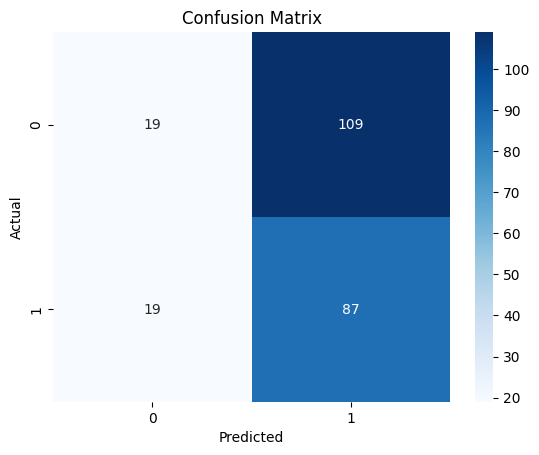

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


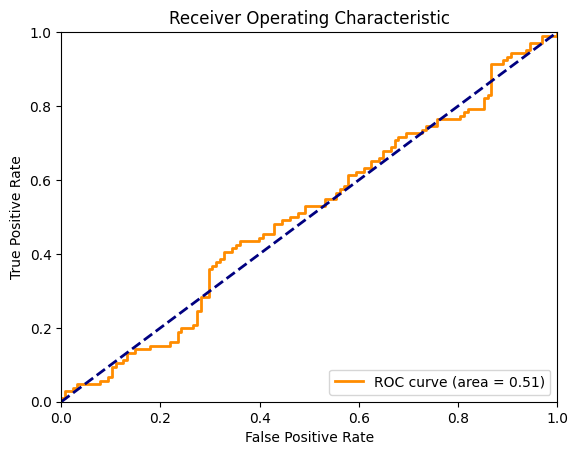

In [79]:
#Random forest

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier  # Or your chosen model
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from scipy.stats import randint

# Prepare your data
features = ['r_EMA10', 'r_EMA50', 'Sector score', 'Industry score', 'new_highs_to_lows',
            'RSI10','RSI5', 'Relvol', 'updays_last_10', 'advances', 'above200', 'crs20']
target = 'Target'

filtered_cd = cd[(cd['Industry'] != 'Biotechnology')]

X = filtered_cd[features]
y = filtered_cd[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

# Create and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring='precision')  # Adjust n_iter, cv, and scoring as needed

# Fit the random search to the data
random_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")


### Model performance ###

# Use the best model for prediction
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### ROC - Receiver Operating Characteristic ###
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [72]:
cd

,Date,Ticker,No.,Company,Sector,Industry,Country,Market Cap,Short Ratio,Perf Week,Perf Month,Perf Quart,Volatility W,Volatility M,SMA20,SMA50,RSI,Avg Volume,Rel Volume,Price,Change,Volume,Sector score,Industry score,Advancing issues,Declining issues,New High,New Low,Above SMA50,Below SMA50,Above SMA200,Below SMA200,above200,above50,advances,new_highs_to_lows,open,high,low,close,adj close,volume,Relvol,RSI5,RSI10,RSI14,lowRSI10,ROC,ROC3,ROC5,MOM,ADR5,ADR21,kfr10,EMA10,EMA20,EMA50,EMA100,SMA150,SMA200,r_EMA10,r_EMA20,r_EMA50,r_EMA100,r_SMA150,r_SMA200,BB_up,BB_mid,BB_lo,KB_up,KB_lo,ENGULFING,DOJI,HAMMER,DRAGONFLY,MORNINGST,HiLows,HiTypp,smooth,hihi,lolo,range_hilo,hi10,lo10,updays_last_10,updays,downdays,typp,tlr5,tlr10,clr5,hlr5,llr5,clr10,hlr10,llr10,blow1,blow2,bhigh1,bhigh2,FWD1,FWD3,FWD5,FWD10,FWD20,DD5,UM5,DD10,UM10,DD20,UM20,SP,crs20,crs50,Target
idx,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55653,2024-01-10,FDMT,80,4D Molecular Therapeutics Inc,Healthcare,Biotechnology,USA,818230000,10.58,-0.0511,0.2811,0.5923,0.0609,0.0667,0.0000,0.2902,56.46,372040,0.62,19.14,-0.0180,232176,72.7,95.8,5097,3998,430,181,7211,2248,6245,3214,0.660218,0.762343,0.538852,2.375691,19.42,19.86,18.82,19.14,19.14,232200.0,0.4907,36.1527,51.3433,56.4634,51.3433,-0.0180,-0.0230,-0.0511,-1.03,0.0609,0.0667,-0.3857,19.7637,18.8837,16.4895,15.6073,15.7234,16.2479,0.0326,-0.0134,-0.1385,-0.1846,-0.1785,-0.1511,22.9919,19.3765,15.7611,21.2557,16.5118,0,0,0,0,0,0,0,4.0,21.22,18.82,2.0512,0.0851,0.0000,2.0,0,2,19.2733,19.3627,19.4204,19.326,19.904,18.858,19.3264,20.0969,18.8378,18.0491,17.5811,20.6029,21.1809,-0.0178,-0.0366,-0.1092,-0.0031,0.4054,-0.1202,0.0319,-0.1306,0.0319,-0.1306,0.8605,4783.45,0.2826,0.5735,1
17903,2022-08-12,APLS,46,"Apellis Pharmaceuticals, Inc.",Healthcare,Biotechnology,USA,7010000000,9.12,0.0730,0.4937,0.8545,0.0479,0.0553,0.1999,0.3740,77.29,1080000,1.63,67.95,0.0380,1760520,27.3,45.8,6592,1598,129,55,6936,1611,2780,5767,0.32526,0.811513,0.771265,2.345455,66.10,68.87,66.10,67.95,67.95,1760500.0,1.2158,83.2606,80.0836,77.2884,66.1211,0.0380,0.0569,0.0730,4.62,0.0479,0.0553,0.6926,62.7528,58.7738,52.7838,49.1954,46.6956,45.5765,-0.0765,-0.1350,-0.2232,-0.2760,-0.3128,-0.3293,69.3317,57.7235,46.1153,65.0868,52.4609,0,0,0,0,0,1,1,1.0,68.87,61.28,2.5201,0.0000,-0.1716,6.0,1,0,67.6400,67.5220,67.9868,67.776,68.514,66.276,68.2873,69.4002,66.2729,64.0165,62.5165,71.5355,72.2735,0.0102,0.0106,-0.0446,-0.1784,-0.0100,-0.0521,0.0299,-0.1909,0.0299,-0.2026,0.0302,4280.15,0.3312,0.5746,0
72341,2024-07-29,GSHD,84,Goosehead Insurance Inc,Financial,Insurance - Diversified,USA,2230000000,12.64,0.3395,0.5379,0.5944,0.0754,0.0464,0.4025,0.4349,84.78,316170,1.02,88.49,-0.0021,322732,90.9,84.0,3810,5449,481,115,5981,3607,6633,2955,0.691802,0.623801,0.397372,4.182609,88.56,88.78,85.54,88.49,88.49,322700.0,0.9297,91.7484,87.9913,84.7802,65.3699,-0.0021,0.3469,0.3395,22.43,0.0754,0.0464,0.7657,74.4286,68.3645,64.0605,64.5360,68.0055,68.9248,-0.1589,-0.2274,-0.2761,-0.2707,-0.2315,-0.2211,85.0460,64.6485,44.2510,77.1239,59.6051,0,100,0,100,0,1,1,4.0,88.86,64.92,5.2476,0.0009,-0.2874,6.0,0,1,87.6033,90.3740,84.2868,92.048,92.826,86.248,85.8233,86.8251,80.2122,87.9449,82.1449,96.1511,96.9291,0.0223,-0.0155,-0.0318,-0.0764,-0.0620,-0.0597,0.0453,-0.0829,0.0453,-0.1035,0.0453,5463.54,0.5397,0.4171,0
66121,2024-05-06,SIGA,134,SIGA Technologies Inc,Healthcare,Drug Manufacturers - Specialty & Generic,USA,738940000,5.63,0.1767,0.1443,1.4732,0.0577,0.0507,0.1666,0.3687,76.55,879400,1.87,10.39,0.0236,1645547,27.3,27.1,6833,2298,528,88,5272,4221,6277,3216,0.661224,0.555357,0.719794,6.0,10.45,10.83,10.23,10.39,10.39,1648000.0,2.1303,92.5139,79.9979,75.3779,52.0939,0.0236,0.1148,0.1767,1.56,0.0577,0.0506,0.8571,9.3824,9.0255,8.0843,7.1303,6.1374,5.8319,-0.0970,-0.1313,-0.2219,-0.3137,-0.4093,-0.4387,10.0604,8.9760,7.8916,10.0375,8.0135,0,0,0,0,0,1,1,5.0,10.83,8.43,3.4537,0.0000,-0.1799,7.0,4,0

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Prepare your data
features = ['r_EMA10', 'r_EMA50', 'Sector score', 'Industry score', 'new_highs_to_lows',
            'RSI10','RSI5', 'Relvol', 'updays_last_10', 'advances', 'above200', 'crs20']
target = 'Target'

filtered_cd = cd[(cd['Industry'] != 'Biotechnology')]

X = filtered_cd[features]
y = filtered_cd[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a smaller hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
}

# Create and train the XGBoost model directly (without GridSearchCV)
model = XGBClassifier(objective='binary:logistic', random_state=42,
                      n_estimators=100, learning_rate=0.1, max_depth=3)  # Example parameters

# Create GridSearchCV object instead of RandomizedSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")


### Model performance ###

# Use the best model for prediction
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)


# Make predictions
y_pred = model.predict(X_test_scaled)  # Predict on scaled test data

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")

# Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [45]:
az = ta['AAOI']
az = az[['Ticker',	'open',	'high',	'low',	'close',	'adj close',	'volume']].copy()
az['pct_chang'] = np.sign(az.close.pct_change())
az['BullVolume?'] = ((az['volume']*az['pct_chang']).rolling(10).sum() > 0).astype(int)
az


Price,Ticker,open,high,low,close,adj close,volume,pct_chang,BullVolume?
Date,,,,,,,,,
2021-09-23,AAOI,7.05,7.24,7.01,7.16,7.16,228400,NaN,0
2021-09-24,AAOI,7.17,7.33,7.08,7.24,7.24,242800,1.0,0
2021-09-27,AAOI,7.27,7.51,7.24,7.24,7.24,297000,0.0,0
2021-09-28,AAOI,7.18,7.29,7.05,7.05,7.05,248700,-1.0,0
2021-09-29,AAOI,7.13,7.18,6.98,7.04,7.04,273400,-1.0,0
...,...,...,...,...,...,...,...,...,...
2024-12-10,AAOI,33.84,36.09,31.61,33.09,33.09,5844900,-1.0,0
2024-12-11,AAOI,34.00,34.74,31.44,33.67,33.67,3923000,1.0,0
2024-12-12,AAOI,33.50,35.45,32.95,33.00,33.00,2692500,-1.0,0


# Export data fro ML

In [81]:
# Create a dictionary containing both DataFrames
data = {'df': df, 'ohlc': ohlc}

# Save the dictionary to a pickle file
pd.to_pickle(data, 'df_ohlc_4ML_1500_obs.pkl')

Accuracy: 0.5483870967741935
Precision: 0.5757575757575758
Confusion Matrix:
[[32 14]
 [28 19]]


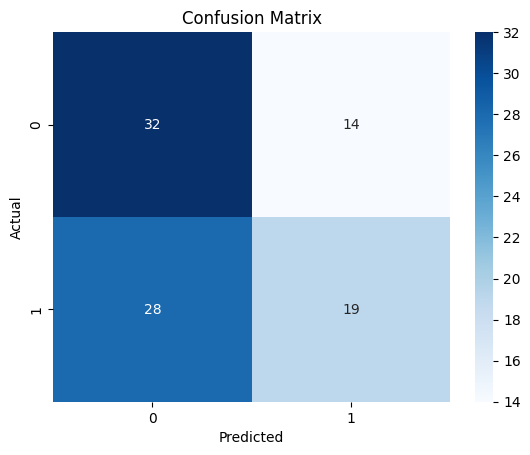

In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV  # Or RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Or your chosen model
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

# 1. Prepare your data
features = ['Sector score', 'Industry score', 'above200', 'above50', 'advances', 'new_highs_to_lows', 'crs20']
target = 'Target'

X = cd[features]
y = cd[target]

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Create a StandardScaler object
scaler = StandardScaler()

# 4. Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# 5. Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# 6. Create and train the model with best hyperparameters
model = RandomForestClassifier(**best_params, random_state=42)  # Use best_params here
model.fit(X_train_scaled, y_train)

# 7. Make predictions on the scaled test data
y_pred = model.predict(X_test_scaled)

# 8. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")

# 9. Generate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# prompt: df dataframe: remove obervations with Biotechnology as Industry

# Assuming 'df' is your DataFrame
df = df[df['Industry'] != 'Biotechnology']

df

In [75]:
# prompt: what percentage of obserations with Target 1 have Bullvolume? 1 as well?

# Assuming 'cd' DataFrame from your provided code is available.
# Calculate the percentage

target_1_with_bullvolume_1 = cd[(cd['Target'] == 1) & (cd['BullVolume?'] == 1)].shape[0]
target_1_total = cd[cd['Target'] == 1].shape[0]

if target_1_total > 0 :
  percentage = (target_1_with_bullvolume_1 / target_1_total) * 100
  print(f"Percentage of observations with Target 1 and BullVolume 1: {percentage:.2f}%")
else:
  print("No observations found with Target 1.")

Percentage of observations with Target 1 and BullVolume 1: 45.22%


In [76]:
#@title show_histogram_feature_distribution { form-width: "25%", display-mode: "form" }
def feat_dist(dataframe, features, cond, drop_outliers=True, stat="count"):
  '''
  Split the data in groups (e.g. winner and losers), based on a condition. For
  any given feature within df columns, plot its the distribution for each group.
  '''
  # keep the orginal df copy as local to be alterated for each feature analysed
  df_original=dataframe.copy()
  # use cond to classify the observations in the df, if not already classified
  if 'classifier' not in df_original.columns: df_original['classifier'] = cond

  def iqr_subset(df, column, whisker_width=1.5):
    """Remove outliers from a dataframe by column, including optional
       whiskers, removing rows for which the column value are
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    Args:
        df (`:obj:pd.DataFrame`): A pandas dataframe to subset
        column (str): Name of the column to calculate the subset from.
        whisker_width (float): Optional, loosen the IQR filter by a
                               factor of `whisker_width` * IQR.
    Returns:
        (`:obj:pd.DataFrame`): Filtered dataframe
    """
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    dropped = round(100 - len(df.loc[filter].index) / len(df.index) * 100, 2)
    return df.loc[filter], dropped


  for i in features:
    # reinit the original df given as param and dropped outliers
    df, dropped  = df_original.copy(), 0
    try:
      discrete = i in ['Sector', 'Industry', 'smooth']
      d = {True: "bars", False: "step"}
      # drop outliers only if requested and if unique values is high
      if (drop_outliers == True) & (df[i].nunique()>200):
        df, dropped = iqr_subset(df, i, 2.5)

      fig, ax = plt.subplots(figsize=[15, 5], tight_layout=True)
      g = sns.histplot(df, x=i, hue='classifier', hue_order=df.classifier.unique(),
                  element=d[discrete], discrete=discrete,
                  bins="auto", stat=stat, common_norm=False,
                  kde= not discrete, kde_kws={'bw_adjust':0.75},
                  legend=True, ax=ax,)

      new_labels = [str(i)+': '+str(len(df[df['classifier'] == i])) for i in df.classifier.unique()]
      ax.legend(handles = ax.get_legend().legendHandles, labels = new_labels)
      sns.move_legend(ax, "upper left")
      ax.xaxis.label.set_size(12)
      if drop_outliers == True:
        plt.text(0.01,0.84, f'Outliers dropped: {dropped}%', ha='left', size='small', color='black', transform=ax.transAxes)

      if i in ['Sector', 'Industry', 'Date']:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

      if df[i].dtype.kind in 'biufc': #if column is numeric, compute median
        plt.axvline(x=df[i].median(), color='red', ls=':', lw=0.6)
        ax.text(s='med: {:.4f}'.format(df[i].median()), x=df[i].median(), y=0.1,
                color='red', ha='right', va='bottom', rotation=90)
      if not discrete:
        ax2 = ax.twinx()
        sns.ecdfplot(data=df, x=i, hue="classifier", hue_order=df.classifier.unique(),
                     ax=ax2, legend=False, lw=0.7, ls='-', stat='proportion')
        ax2.set_ylabel('ECDF Proportion')
        plt.yticks([0.2, 0.4, 0.5, 0.6, 0.8, 1])
        ax2.yaxis.grid(which="major", color='black', linestyle=':', lw=0.5)
    except KeyError:
      print(f'Feature {i} does not exist is df columns')


<ipython-input-76-9d1e01e84436>:52: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  ax.legend(handles = ax.get_legend().legendHandles, labels = new_labels)


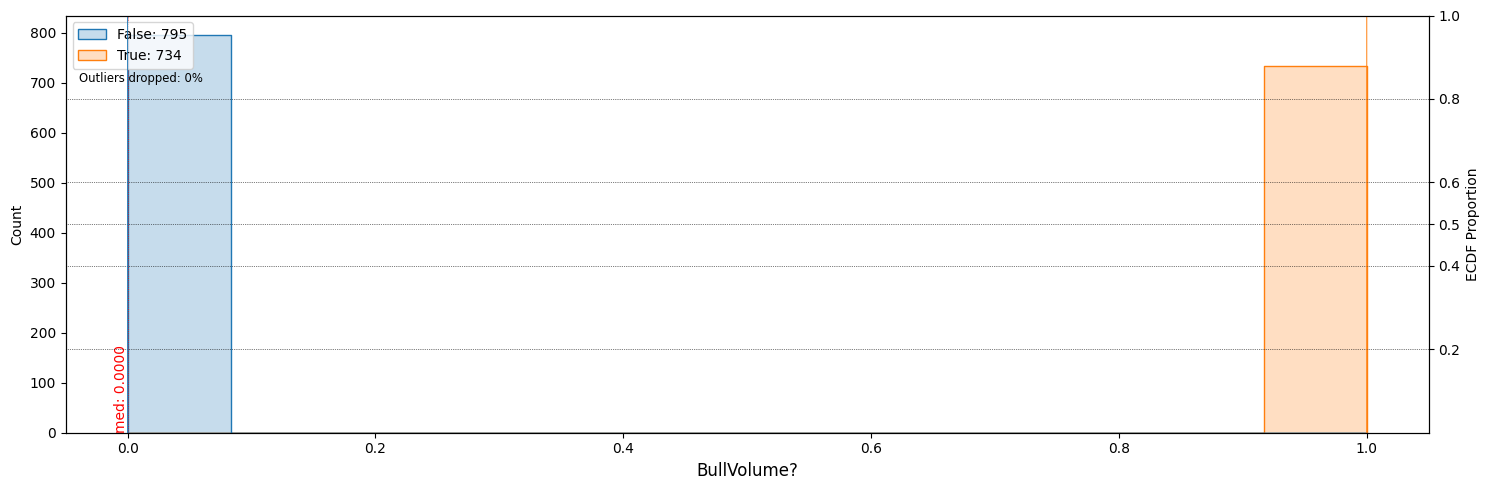

In [78]:
import seaborn as sns
cond1 = (cd['BullVolume?'] == 1)
features = ['BullVolume?']

feat_dist(cd, features, cond1)